In [38]:
%matplotlib inline

import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np
import sys
import scipy
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import random

### Data Exploration

In [39]:
#import seller listings data
df = pd.read_csv('/users/caroline.hughes/anaconda3/envs/py38_env/seller listings.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   seller                    19996 non-null  int64  
 1   seller return rate        19996 non-null  float64
 2   seller rating             19996 non-null  float64
 3   Number of units sold      19996 non-null  int64  
 4   Number of Units Returned  19996 non-null  int64  
 5   brand                     19995 non-null  object 
 6   product type              19996 non-null  object 
 7   listing price             19996 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.2+ MB


In [41]:
#average seller return rate
df['seller return rate'].mean()

0.06646879375875175

array([[<Axes: title={'center': 'seller return rate'}>]], dtype=object)

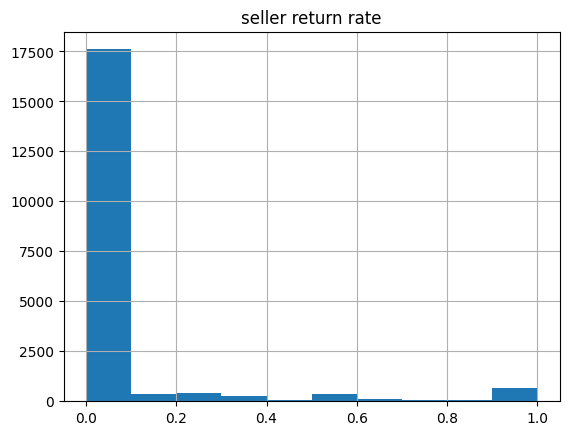

In [42]:
#seller return rate distribution
df.hist(column='seller return rate')


In [43]:
#average seller rating
df['seller rating'].mean()

0.6232946589317864

array([[<Axes: title={'center': 'seller rating'}>]], dtype=object)

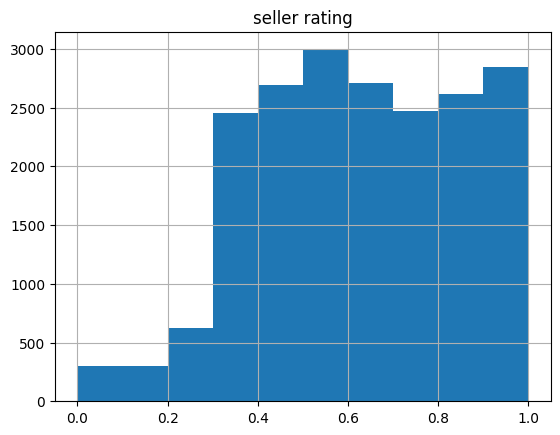

In [44]:
#seller rating distribution
df.hist(column='seller rating')


### Anomaly detection using seller return rate & seller rating

### Method: Isolation Forest

In [45]:
anomaly_inputs = ['seller return rate', 'seller rating']

In [46]:
#setting contamination factor to 10% based on industry average research
#contamination factor = expected % of outliers in data
IF = IsolationForest(contamination = 0.1, random_state = 123)
IF.fit(df[anomaly_inputs])
#lower anomaly score = more iregular
df['anomaly_scores'] = IF.decision_function(df[anomaly_inputs])
#identifies if row is outlier/inlier
df['anomaly_IF'] = IF.predict(df[anomaly_inputs])

In [47]:
df.loc[:, ['seller', 'seller return rate', 'seller rating', 'anomaly_scores', 'anomaly_IF']]

,seller,seller return rate,seller rating,anomaly_scores,anomaly_IF
0,7990,1.0,0.07,-0.099644,-1
1,6844,1.0,0.19,-0.053927,-1
2,13851,1.0,0.70,-0.113655,-1
3,1142,1.0,0.03,-0.116351,-1
4,5957,1.0,0.13,-0.075532,-1
...,...,...,...,...,...
19991,19900,0.0,0.42,0.191071,1
19992,10201,0.0,0.72,0.209167,1
19993,10203,0.0,0.37,0.180468,1
19994,10204,0.0,0.68,0.209245,1


### Visualizing outliers/Inliers

In [48]:
def outlier_plot(data, outlier_method_name, x_var, y_var, 
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):

    print(f'Outlier Method: {outlier_method_name}')
    
    method = f'{outlier_method_name}_anomaly'
    
    print(f"Number of anomalous values {len(data[data['anomaly_IF']==-1])}")
    print(f"Number of non anomalous values {len(data[data['anomaly_IF']==1])}")
    print(f'Total Number of Values: {len(data)}')
    
    g = sns.FacetGrid(data, col='anomaly_IF', height=4, hue='anomaly_IF', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly_IF']== -1])} points")
    axes[1].set_title(f"Intliers\n{len(data[data['anomaly_IF']== 1])} points")
    return g

Outlier Method: Isolation Forest
Number of anomalous values 2000
Number of non anomalous values 17996
Total Number of Values: 19996


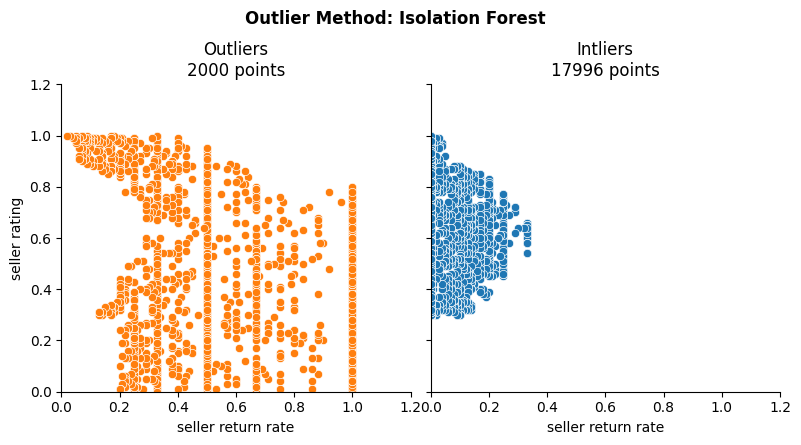

In [49]:
outlier_plot(df, "Isolation Forest", "seller return rate", "seller rating", [0,1.2], [0,1.2])

### Anomaly Detection using seller return rate & seller rating

### Method: Zscore

In [50]:
mean_rate = df['seller return rate'].mean()

# ddof is the degrees of freedom correction 
# for population standard deviation ddof=0
stdev_rate = df['seller return rate'].std(ddof=0)

print('Mean return rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean return rate is 0.066
Standard deviation is 0.211


In [51]:
mean_rate = df['seller rating'].mean()

# ddof is the degrees of freedom correction 
# for population standard deviation ddof=0
stdev_rate = df['seller rating'].std(ddof=0)

print('Mean seller rating is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean seller rating is 0.623
Standard deviation is 0.226


In [52]:
zscore_rate = ss.zscore(df['seller return rate'], ddof=0)
df_zscore = df.assign(zscore_rr=zscore_rate)
zscore_rate_rating = ss.zscore(df_zscore['seller rating'], ddof=0)
df_zscore = df_zscore.assign(zscore_rate_rating=zscore_rate_rating)
df_zscore.head(8)

,seller,seller return rate,seller rating,Number of units sold,Number of Units Returned,brand,product type,listing price,anomaly_scores,anomaly_IF,zscore_rr,zscore_rate_rating
0,7990,1.0,0.07,1,1,versace,jackets/vests,333,-0.099644,-1,4.421791,-2.446211
1,6844,1.0,0.19,3,3,saks fifth avenue,modern knits,111,-0.053927,-1,4.421791,-1.915670
2,13851,1.0,0.70,1,1,saks fifth avenue,modern knits,111,-0.113655,-1,4.421791,0.339127
3,1142,1.0,0.03,4,4,commando,commando/herlook (intimates),48,-0.116351,-1,4.421791,-2.623057
4,5957,1.0,0.13,1,1,badgley mischka,cocktail dress,385,-0.075532,-1,4.421791,-2.180940
5,2773,1.0,0.16,1,1,ere perez,ere perez cosmetics,27,-0.063114,-1,4.421791,-2.048305
6,8926,1.0,0.33,1,1,cellcosmet switzerland,face cellcosmet,284,-0.070910,-1,4.421791,-1.296706
7,6480,1.0,0.26,1,1,farm rio,outerwear,326,-0.058707,-1,4.421791,-1.606188


### Visualizing outliers/inliers above 2 std dev threshold: seller return rate

In [53]:
def plot_anomaly(score_data, threshold):
    
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='inliers')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. return rate', fontweight='bold')
    plt.xlabel('Ranked Return Rates')
    plt.ylabel('Z-score')
    plt.show()

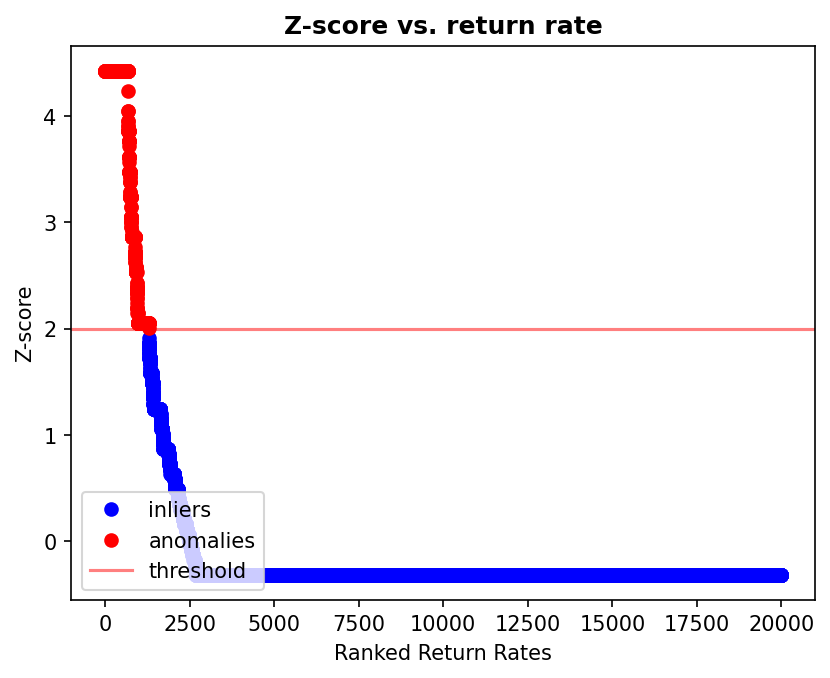

In [54]:
plot_anomaly(df_zscore['zscore_rr'], 2)


### Adding outlier flag for return rates 2 std deviations above the avg and seller ratings 2 std deviations below the avg

In [57]:
df_zscore['anomaly_rr_zscore'] = np.where(df_zscore['zscore_rr']>=2, True, False)
df_zscore['anomaly_rating_zscore'] = np.where(df_zscore['zscore_rate_rating']<=-2, True, False)
df_zscore


,seller,seller return rate,seller rating,Number of units sold,Number of Units Returned,brand,product type,listing price,anomaly_scores,anomaly_IF,zscore_rr,zscore_rate_rating,anomaly_rr_zscore,anomaly_rating_zscore
0,7990,1.0,0.07,1,1,versace,jackets/vests,333,-0.099644,-1,4.421791,-2.446211,True,True
1,6844,1.0,0.19,3,3,saks fifth avenue,modern knits,111,-0.053927,-1,4.421791,-1.915670,True,False
2,13851,1.0,0.70,1,1,saks fifth avenue,modern knits,111,-0.113655,-1,4.421791,0.339127,True,False
3,1142,1.0,0.03,4,4,commando,commando/herlook (intimates),48,-0.116351,-1,4.421791,-2.623057,True,True
4,5957,1.0,0.13,1,1,badgley mischka,cocktail dress,385,-0.075532,-1,4.421791,-2.180940,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,19900,0.0,0.42,4,0,gigi new york,gigi new york (handbags),158,0.191071,1,-0.314838,-0.898801,False,False
19992,10201,0.0,0.72,2,0,hatley,bottoms,28,0.209167,1,-0.314838,0.427551,False,False
19993,10203,0.0,0.37,20,0,teri jon by rickie freeman,cocktail dress,392,0.180468,1,-0.314838,-1.119859,False,False
19994,10204,0.0,0.68,4,0,kate spade new york,high heel sandals,139,0.209245,1,-0.314838,0.250704,False,False


### Anomaly Detection on listing price

In [58]:
df_prices = pd.read_csv('/users/caroline.hughes/anaconda3/envs/py38_env/brand, product retail prices.csv')

In [59]:
df_prices

,brand,product type,retail price
0,zwillinger's,dresses,4800.00
1,zwillinger's,dresses,5400.00
2,zwillinger's,dresses,3800.00
3,zwillinger's,accessories,850.00
4,zwilling j.a. henckels,dropship kitchenware,19.99
...,...,...,...
90915,NaN,boy tops,40.00
90916,NaN,boy tops,36.00
90917,NaN,boy sweaters,40.00
90918,NaN,boy overall/romper/shortall,35.00


In [60]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90920 entries, 0 to 90919
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         90899 non-null  object 
 1   product type  90920 non-null  object 
 2   retail price  90920 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


### Creating avg and std values for the brand/product type combinations

In [61]:
df_prices["brand, product type"] = df_prices["brand"].astype(str) + " " + df_prices["product type"].astype(str)
df_zscore["brand, product type"] = df_zscore["brand"].astype(str) + " " + df_zscore["product type"].astype(str)


In [62]:
df_prices_mean = df_prices.groupby(['brand, product type'])['retail price'].mean().reset_index()
df_prices_mean

,"brand, product type",retail price
0,1017 alyx 9sm 1017 alyx9sm rtw,825.000000
1,1017 alyx 9sm alyx (hats),256.500000
2,1017 alyx 9sm alyx jewelry,275.000000
3,1017 alyx 9sm boots (footwear),710.000000
4,1017 alyx 9sm casual slipon rubber sole,230.000000
...,...,...
16051,zuvi zuvi hair care,349.000000
16052,zwilling beauty zwilling beauty,46.910833
16053,zwilling j.a. henckels dropship kitchenware,155.297802
16054,zwillinger's accessories,850.000000


In [63]:
df_prices_std = df_prices.groupby(['brand, product type'])['retail price'].agg(np.std, ddof=0).reset_index()
prices_grouped = pd.merge(df_prices_mean, df_prices_std, on='brand, product type', how='left')
prices_grouped.rename(columns={"retail price_x": "avg_retail_price", "retail price_y": "std_retail_price"}, inplace=True)
prices_grouped

,"brand, product type",avg_retail_price,std_retail_price
0,1017 alyx 9sm 1017 alyx9sm rtw,825.000000,0.000000
1,1017 alyx 9sm alyx (hats),256.500000,0.000000
2,1017 alyx 9sm alyx jewelry,275.000000,85.000000
3,1017 alyx 9sm boots (footwear),710.000000,0.000000
4,1017 alyx 9sm casual slipon rubber sole,230.000000,0.000000
...,...,...,...
16051,zuvi zuvi hair care,349.000000,0.000000
16052,zwilling beauty zwilling beauty,46.910833,30.041035
16053,zwilling j.a. henckels dropship kitchenware,155.297802,253.997665
16054,zwillinger's accessories,850.000000,0.000000


### Merging aggregated retail price dataset to df_zscore

In [64]:
joined_df = pd.merge(df_zscore, prices_grouped, on='brand, product type', how='left')
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19996 entries, 0 to 19995
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   seller                    19996 non-null  int64  
 1   seller return rate        19996 non-null  float64
 2   seller rating             19996 non-null  float64
 3   Number of units sold      19996 non-null  int64  
 4   Number of Units Returned  19996 non-null  int64  
 5   brand                     19995 non-null  object 
 6   product type              19996 non-null  object 
 7   listing price             19996 non-null  int64  
 8   anomaly_scores            19996 non-null  float64
 9   anomaly_IF                19996 non-null  int64  
 10  zscore_rr                 19996 non-null  float64
 11  zscore_rate_rating        19996 non-null  float64
 12  anomaly_rr_zscore         19996 non-null  bool   
 13  anomaly_rating_zscore     19996 non-null  bool   
 14  brand,

### Flagging listings where list price is significantly higher or lower than the avg retail price

In [65]:
joined_df['sig_high_list_price'] = np.where(joined_df['listing price'] >= (joined_df['avg_retail_price'] + (2 * joined_df['std_retail_price'])), True, False)
joined_df['sig_low_list_price'] = np.where(joined_df['listing price'] <= (joined_df['avg_retail_price'] - (2 * joined_df['std_retail_price'])), True, False)


In [66]:
joined_df['anomaly_IF_flag'] = np.where(df_zscore['anomaly_IF']==-1, True, False)


### Final Output file = joined_df

###### Recommendation: investigate the listings flagged as outliers by the isolation forest method (anomaly_IF = TRUE) where the seller has either a significantly higher return rate than avg listings (anomaly_rr_zscore = TRUE) OR a significantly lower seller rating than the avg seller (anomaly_rating_zscore = TRUE). Consider prioritizing investigation on listings with significantly higher listing prices than the avg retail listing price for that brand/product combination (sig_high_list_price = TRUE)

In [67]:
joined_df

,seller,seller return rate,seller rating,Number of units sold,Number of Units Returned,brand,product type,listing price,anomaly_scores,anomaly_IF,zscore_rr,zscore_rate_rating,anomaly_rr_zscore,anomaly_rating_zscore,"brand, product type",avg_retail_price,std_retail_price,sig_high_list_price,sig_low_list_price,anomaly_IF_flag
0,7990,1.0,0.07,1,1,versace,jackets/vests,333,-0.099644,-1,4.421791,-2.446211,True,True,versace jackets/vests,525.000000,233.933751,False,False,True
1,6844,1.0,0.19,3,3,saks fifth avenue,modern knits,111,-0.053927,-1,4.421791,-1.915670,True,False,saks fifth avenue modern knits,182.871429,154.235212,False,False,True
2,13851,1.0,0.70,1,1,saks fifth avenue,modern knits,111,-0.113655,-1,4.421791,0.339127,True,False,saks fifth avenue modern knits,182.871429,154.235212,False,False,True
3,1142,1.0,0.03,4,4,commando,commando/herlook (intimates),48,-0.116351,-1,4.421791,-2.623057,True,True,commando commando/herlook (intimates),97.372391,82.371553,False,False,True
4,5957,1.0,0.13,1,1,badgley mischka,cocktail dress,385,-0.075532,-1,4.421791,-2.180940,True,True,badgley mischka cocktail dress,506.106429,159.549455,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,19900,0.0,0.42,4,0,gigi new york,gigi new york (handbags),158,0.191071,1,-0.314838,-0.898801,False,False,gigi new york gigi new york (handbags),319.483871,152.938291,False,False,False
19992,10201,0.0,0.72,2,0,hatley,bottoms,28,0.209167,1,-0.314838,0.427551,False,False,hatley bottoms,32.000000,9.345231,False,False,False
19993,10203,0.0,0.37,20,0,teri jon by rickie freeman,cocktail dress,392,0.180468,1,-0.314838,-1.119859,False,False,teri jon by rickie freeman cocktail dress,613.835192,222.803438,False,False,False
19994,10204,0.0,0.68,4,0,kate spade new york,high heel sandals,139,0.209245,1,-0.314838,0.250704,False,False,kate spade new york high heel sandals,222.545455,45.399967,False,False,False
